New code


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
train_path = "D:/VIT Chennai/SEM 7/Capstone/ecg full/train"
test_path = "D:/VIT Chennai/SEM 7/Capstone/ecg full/test"

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.utils import plot_model
from glob import glob

In [3]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 284/284 [00:10<00:00, 26.75it/s]


In [4]:
data.shape

(928, 2)

In [5]:
from collections import Counter
Counter(y_data)

Counter({'train\\Normal Person ECG Images (284x12=3408)': 284,
         'train\\ECG Images of Myocardial Infarction Patients (240x12=2880)': 239,
         'train\\ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 233,
         'train\\ECG Images of Patient that have History of MI (172x12=2064)': 172})

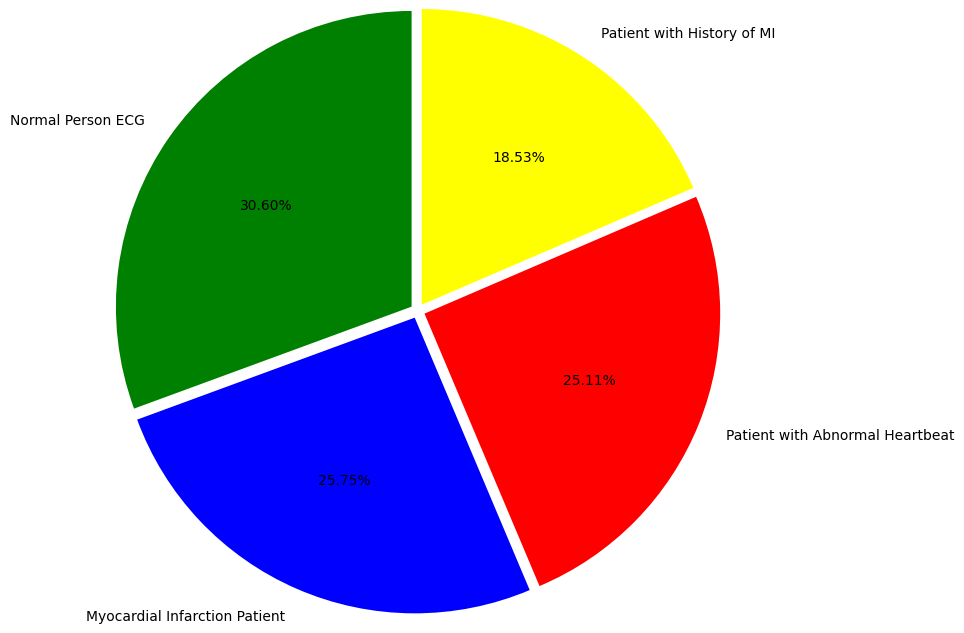

In [10]:
colors = ['green','blue','red','yellow']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05],autopct='%0.2f%%',labels=['Normal Person ECG', 'Myocardial Infarction Patient','Patient with Abnormal Heartbeat','Patient with History of MI'], colors= colors,radius=2)
plt.show()

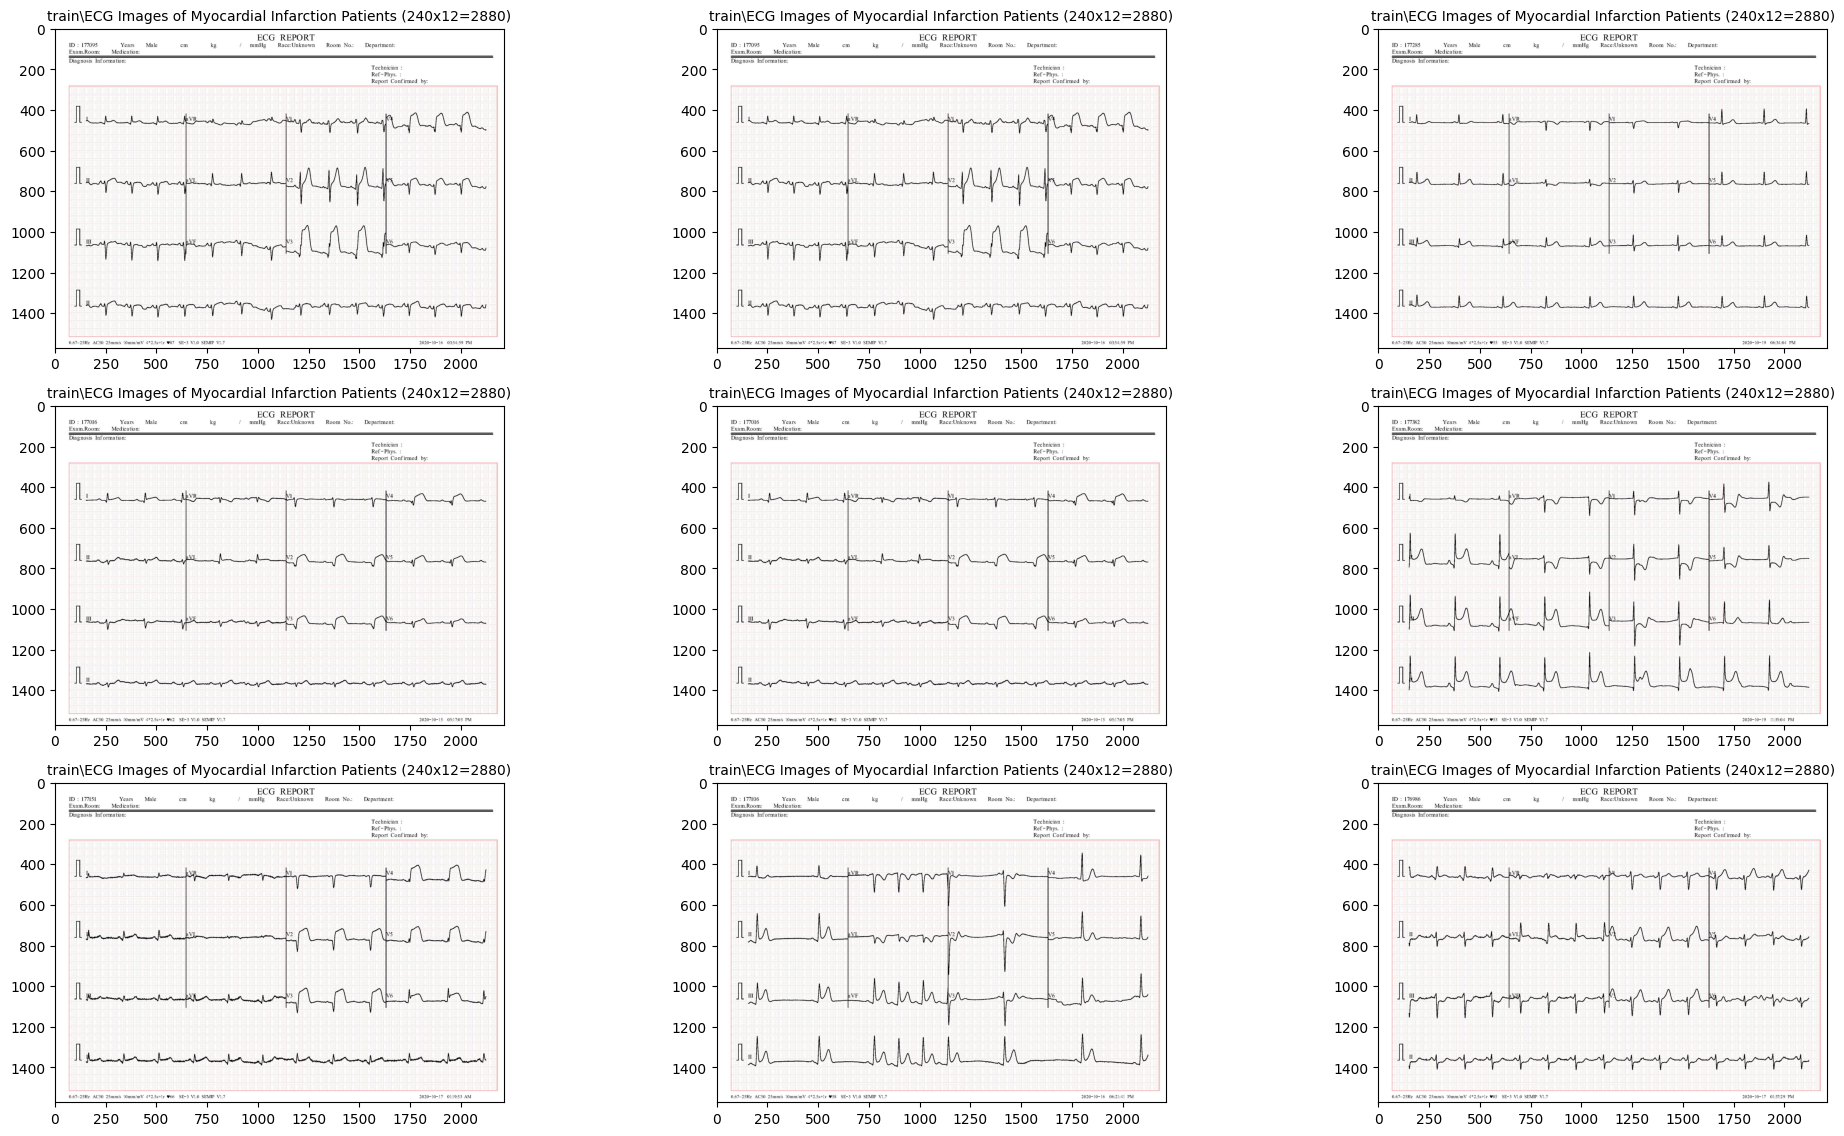

In [19]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(20)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':10})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [20]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  4


In [21]:
x_data = []
y_data = []

for category in glob(test_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 112/112 [00:05<00:00, 20.57it/s]


In [22]:
data.shape

(448, 2)

In [23]:
from collections import Counter
Counter(y_data)

Counter({'test\\ECG Images of Myocardial Infarction Patients (240x12=2880)': 112,
         'test\\ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 112,
         'test\\ECG Images of Patient that have History of MI (172x12=2064)': 112,
         'test\\Normal Person ECG Images (284x12=3408)': 112})

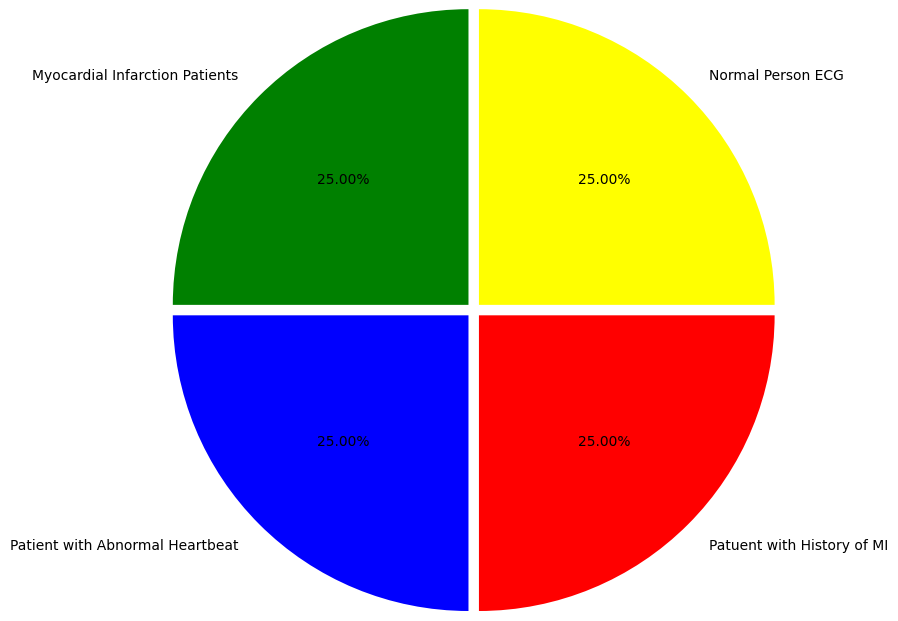

In [24]:
colors = ['green','blue','red','yellow']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05],autopct='%0.2f%%',labels=['Myocardial Infarction Patients', 'Patient with Abnormal Heartbeat','Patuent with History of MI','Normal Person ECG'], colors= colors,radius=2)
plt.show()

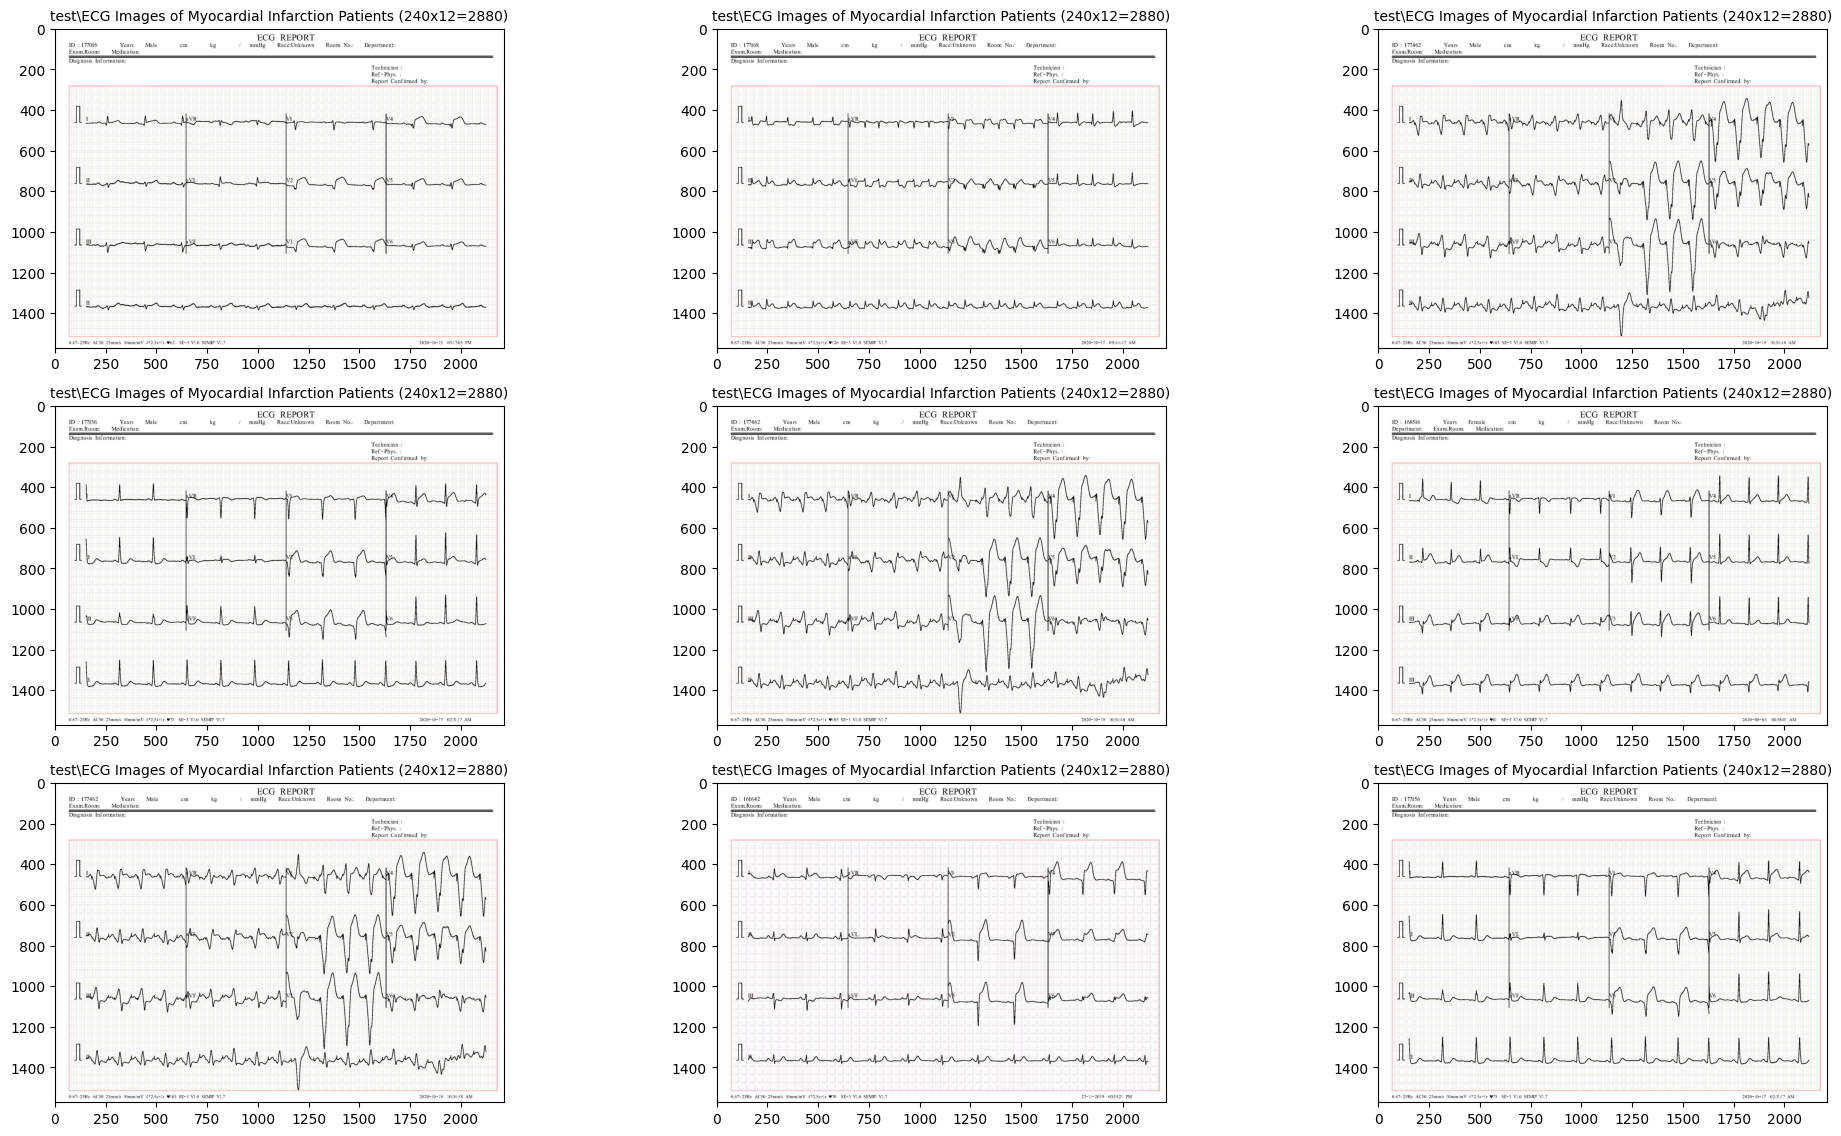

In [26]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(20)
    plt.title('{0}'.format(data.label[index]),fontdict={'size':10})
    plt.imshow(data.image[index])
    plt.tight_layout()

Model Building

In [38]:
train_generator = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
test_generator = ImageDataGenerator(rescale=1./255.)

In [41]:
train_datagen = train_generator.flow_from_directory(
    train_path,
    batch_size=10,
    target_size=(224, 224)
)
test_datagen = test_generator.flow_from_directory(
    test_path,
    batch_size=10,
    target_size=(224, 224)
)

Found 928 images belonging to 4 classes.


Found 448 images belonging to 4 classes.


ResNet 

In [42]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model_res = Model(inputs=base_model.input, outputs=predictions)

model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_res = model_res.fit(train_datagen, epochs=25, validation_data=test_datagen)

Epoch 1/25
93/93 [==============================] - 91s 944ms/step - loss: 2.2754 - accuracy: 0.2457 - val_loss: 1.4044 - val_accuracy: 0.3795
Epoch 2/25
93/93 [==============================] - 78s 836ms/step - loss: 1.9902 - accuracy: 0.2888 - val_loss: 1.4707 - val_accuracy: 0.2478
Epoch 3/25
93/93 [==============================] - 78s 837ms/step - loss: 1.7773 - accuracy: 0.2953 - val_loss: 1.4269 - val_accuracy: 0.2656
Epoch 4/25
93/93 [==============================] - 79s 855ms/step - loss: 1.7701 - accuracy: 0.2909 - val_loss: 1.3379 - val_accuracy: 0.3795
Epoch 5/25
93/93 [==============================] - 86s 929ms/step - loss: 1.6913 - accuracy: 0.2780 - val_loss: 1.4271 - val_accuracy: 0.2500
Epoch 6/25
93/93 [==============================] - 86s 920ms/step - loss: 1.6405 - accuracy: 0.2888 - val_loss: 1.3358 - val_accuracy: 0.3929
Epoch 7/25
93/93 [==============================] - 85s 911ms/step - loss: 1.5734 - accuracy: 0.2748 - val_loss: 1.5383 - val_accuracy: 0.2701

Inception V3

In [44]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model_inc = Model(inputs=base_model.input, outputs=predictions)

model_inc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_inc = model_inc.fit(train_datagen, epochs=25, validation_data=test_datagen)

Epoch 1/25
93/93 [==============================] - 115s 1s/step - loss: 2.0528 - accuracy: 0.3222 - val_loss: 1.7162 - val_accuracy: 0.2589
Epoch 2/25
93/93 [==============================] - 102s 1s/step - loss: 1.8037 - accuracy: 0.3491 - val_loss: 1.5295 - val_accuracy: 0.2991
Epoch 3/25
93/93 [==============================] - 104s 1s/step - loss: 1.6935 - accuracy: 0.3513 - val_loss: 1.5191 - val_accuracy: 0.2946
Epoch 4/25
93/93 [==============================] - 107s 1s/step - loss: 1.5381 - accuracy: 0.3728 - val_loss: 1.7354 - val_accuracy: 0.2500
Epoch 5/25
93/93 [==============================] - 102s 1s/step - loss: 1.4875 - accuracy: 0.3976 - val_loss: 1.4769 - val_accuracy: 0.3259
Epoch 6/25
93/93 [==============================] - 49s 523ms/step - loss: 1.4090 - accuracy: 0.3901 - val_loss: 1.6524 - val_accuracy: 0.3147
Epoch 7/25
93/93 [==============================] - 48s 521ms/step - loss: 1.4192 - accuracy: 0.4095 - val_loss: 1.2908 - val_accuracy: 0.3728
Epoch 8/2

VGG 16

In [46]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_vgg = model_vgg.fit(train_datagen, epochs=50, validation_data=test_datagen)

Epoch 1/50
93/93 [==============================] - 252s 3s/step - loss: 2.0771 - accuracy: 0.3114 - val_loss: 1.3843 - val_accuracy: 0.2500
Epoch 2/50
93/93 [==============================] - 217s 2s/step - loss: 1.6517 - accuracy: 0.4062 - val_loss: 1.4679 - val_accuracy: 0.2500
Epoch 3/50
93/93 [==============================] - 192s 2s/step - loss: 1.5667 - accuracy: 0.4213 - val_loss: 1.5093 - val_accuracy: 0.3237
Epoch 4/50
93/93 [==============================] - 196s 2s/step - loss: 1.4234 - accuracy: 0.4752 - val_loss: 1.2775 - val_accuracy: 0.4107
Epoch 5/50
93/93 [==============================] - 204s 2s/step - loss: 1.3078 - accuracy: 0.4903 - val_loss: 1.2645 - val_accuracy: 0.5067
Epoch 6/50
93/93 [==============================] - 203s 2s/step - loss: 1.3083 - accuracy: 0.4795 - val_loss: 1.0890 - val_accuracy: 0.5290
Epoch 7/50
93/93 [==============================] - 221s 2s/step - loss: 1.2734 - accuracy: 0.4709 - val_loss: 1.5526 - val_accuracy: 0.3616
Epoch 8/50
93